In [1]:
import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot as plt
from arch import arch_model

In [2]:
qqq = pd.read_excel('data/qqq.xlsx', index_col = 0)
qqq.index = qqq.index.to_period('D')

In [3]:
qqq['Diff'] = np.log(qqq['PRC']).diff()
qqq = qqq.dropna()

In [4]:
qqq['Cumulative'] = (1 + qqq['Diff']).cumprod()

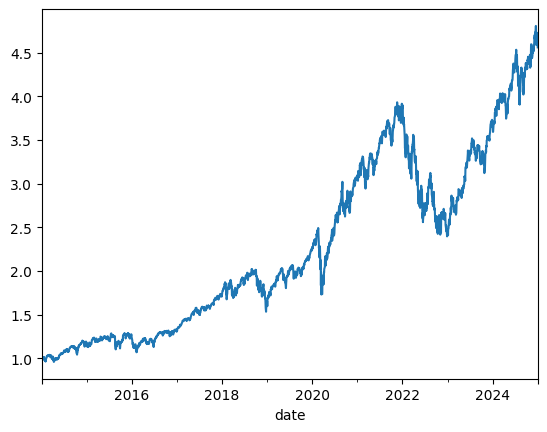

In [25]:
QQQ_plot = qqq['Cumulative'].plot()

In [6]:
skew = qqq['Cumulative'].skew()
kurt = qqq['Cumulative'].kurtosis()
table = pd.DataFrame({'Skewness': [skew], 'Kurtosis': [kurt]}, index=['QQQ'])
table

,Skewness,Kurtosis
QQQ,0.51558,-0.933803


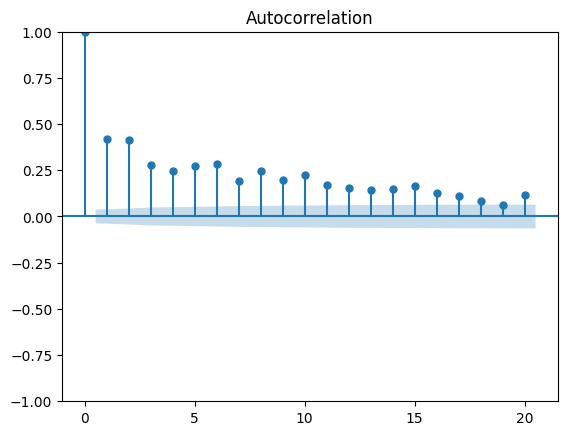

In [7]:
squared_returns_acf = plot_acf((qqq['Diff'])**2, lags=20)

What does this tell you about the time varying volatility in each series?

ARMA for mean

0.8368349734725711


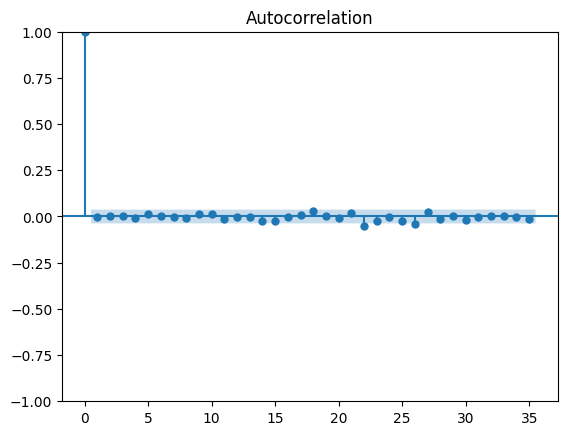

In [8]:
p, q = 3, 6
ARMA_p_q = ARIMA(qqq['Diff'], order = (p,0,q)).fit()
optimal_acf = plot_acf(ARMA_p_q.resid)
results = acorr_ljungbox(ARMA_p_q.resid, lags=20, return_df=True)
print(min(results['lb_pvalue']))

GARCH model for variance

In [9]:
GARCH = arch_model(
    qqq['Diff'] * 100,
    mean = 'ARX',
    vol='GARCH',
    p=2, q=1,
    dist='Normal'
).fit()


print(GARCH.summary())

Iteration:      1,   Func. Count:      7,   Neg. LLF: 256374678277.2755
Iteration:      2,   Func. Count:     17,   Neg. LLF: 2430690.671750485
Iteration:      3,   Func. Count:     25,   Neg. LLF: 4813.439691280813
Iteration:      4,   Func. Count:     34,   Neg. LLF: 5743.679412810805
Iteration:      5,   Func. Count:     42,   Neg. LLF: 4928.797497425521
Iteration:      6,   Func. Count:     50,   Neg. LLF: 4253.522391553436
Iteration:      7,   Func. Count:     56,   Neg. LLF: 4254.172477897808
Iteration:      8,   Func. Count:     63,   Neg. LLF: 4283.421869951379
Iteration:      9,   Func. Count:     71,   Neg. LLF: 4253.326241119412
Iteration:     10,   Func. Count:     77,   Neg. LLF: 4253.324827755282
Iteration:     11,   Func. Count:     83,   Neg. LLF: 4253.324820446474
Iteration:     12,   Func. Count:     88,   Neg. LLF: 4253.324820447231
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4253.324820446474
            Iterations: 12
 

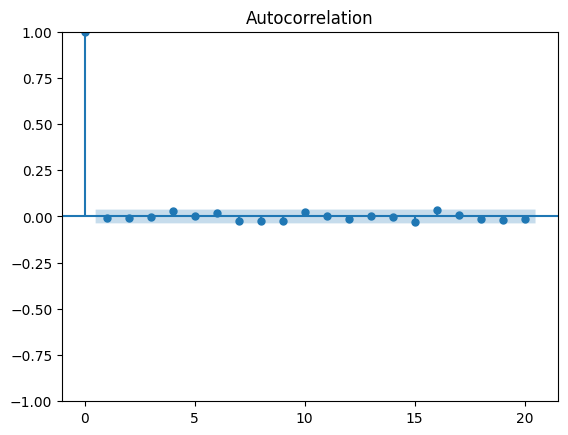

In [10]:
resid = GARCH.std_resid
GARCH_acf = plot_acf(resid**2, lags=20)

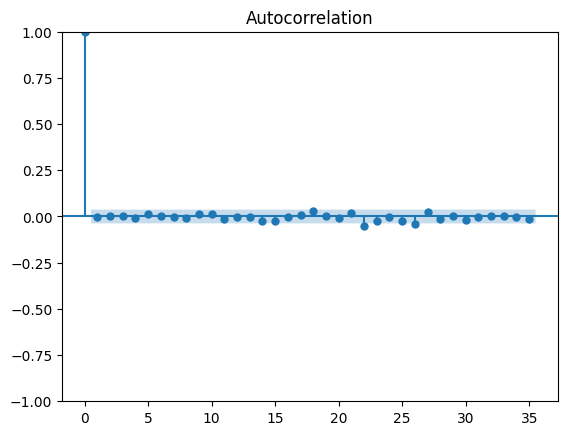

In [11]:
ideal_acf = plot_acf(ARMA_p_q.resid)

In [21]:
month = 21
year = 252

forecasts = GARCH.forecast(horizon=year)
mean_forecast = forecasts.mean.iloc[-1]
variance_forecast = forecasts.variance.iloc[-1]
volatility = np.sqrt(variance_forecast)
volatility

h.001    1.285500
h.002    1.286247
h.003    1.288740
h.004    1.291154
h.005    1.293502
           ...   
h.248    1.379728
h.249    1.379732
h.250    1.379736
h.251    1.379739
h.252    1.379743
Name: 2024-12-31, Length: 252, dtype: float64

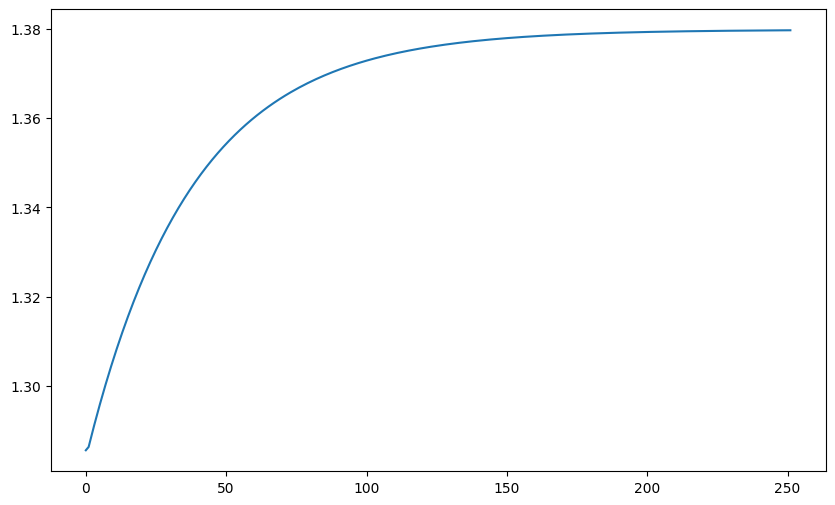

In [20]:
plt.figure(figsize=(10,6))
plt.plot(volatility.values)
plt.show()

In [24]:
annual_variance  = variance_forecast.sum()
annual_volatility = np.sqrt(annual_variance)
annual_volatility = float(annual_volatility)
annual_volatility

21.67580412738358